# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Git import *

In [4]:
# %run "Git.ipynb".ipynb

In [5]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [8]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [9]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [11]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [12]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [13]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [14]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [15]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [16]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_30284\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [17]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [18]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [19]:
holding=Binance.get_inventory()

In [20]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,2316.81,1857.47,1.00,-131.89,-327.46,-459.35,-19.83
BTCUSDT,601.02,937.08,0.50,3.54,336.06,339.60,14.66
SOLUSDT,281.20,269.73,0.15,0.00,-11.47,-11.47,-0.50
JASMYUSDT,387.46,182.43,0.10,0.00,-205.03,-205.03,-8.85
ETHUSDT,250.75,174.91,0.09,0.00,-75.84,-75.84,-3.27
OMUSDT,526.32,140.91,0.08,0.00,-385.41,-385.41,-16.64
TRXUSDT,76.87,138.58,0.07,-10.72,61.71,50.99,2.20
BBUSDT,60.18,12.72,0.01,-39.73,-47.45,-87.18,-3.76
BNBUSDT,1.14,1.11,0.00,-10.61,-0.03,-10.64,-0.46
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.66


In [21]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

54

In [22]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [23]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [24]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [25]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [26]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [27]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [29]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 8919a60a51c773771cc811ddeffae24f70c53878)
✅ File pushed/updated successfully!


In [30]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [31]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [32]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [33]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 48f3ff66c0515aef1f1e31dbec0d93732c82c686)
✅ File pushed/updated successfully!


In [34]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [35]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [36]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [37]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [38]:
# pnl_history['Total']

In [39]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [40]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [41]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [42]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [43]:
pnl_history['Total']

2024-09-23   -242.846960
2024-09-24   -351.229838
2024-09-25   -362.331965
2024-09-26   -276.632747
2024-09-27   -260.113627
                 ...    
2025-06-02   -421.754280
2025-06-03   -435.193882
2025-06-04   -455.772752
2025-06-05   -540.357642
2025-06-06   -362.628744
Name: Total, Length: 257, dtype: float64

<Axes: >

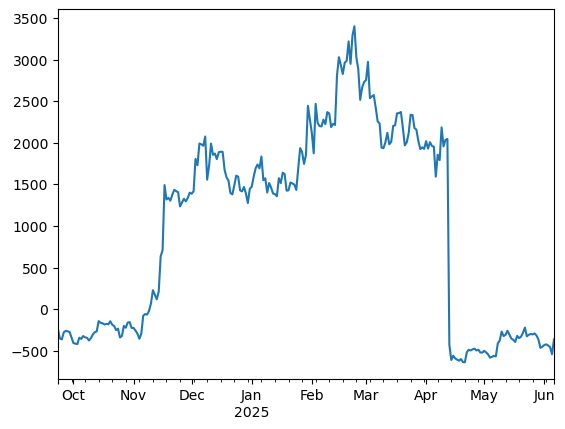

In [44]:
pnl_history['Total'].plot()

In [45]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-06-02      8.143866
2025-06-03    -13.439601
2025-06-04    -20.578871
2025-06-05    -84.584890
2025-06-06    177.728898
Name: Total, Length: 257, dtype: float64

In [46]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-401.9923320761011, -1142.8435479265506)

In [47]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [48]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [49]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [50]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [51]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [52]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [53]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

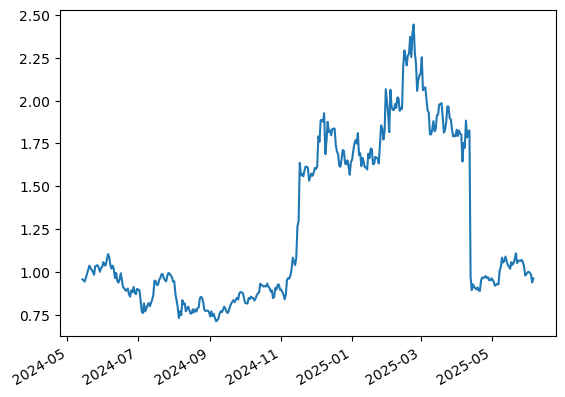

In [54]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

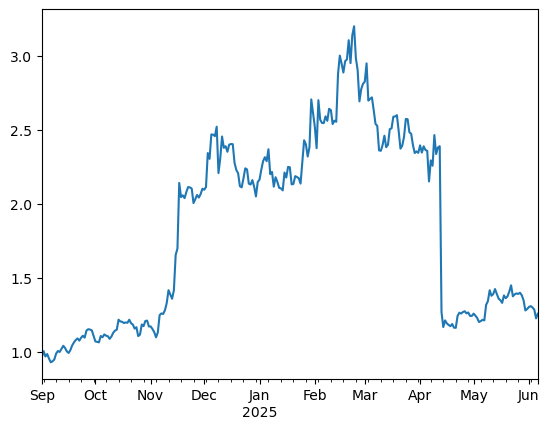

In [55]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [57]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [60]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [61]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [64]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
PAXGUSDT,0.8004
BNBUSDT,0.0473
TRXUSDT,0.0460
BTCUSDT,0.0220
AAVEUSDT,0.0200
SUIUSDT,0.0192
PEPEUSDT,0.0158
OMUSDT,0.0152
XRPUSDT,0.0129
WBTCUSDT,0.0011


In [65]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
PAXGUSDT,0.639303
BTCUSDT,0.300000
TRXUSDT,0.046268
OMUSDT,0.014429


In [66]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

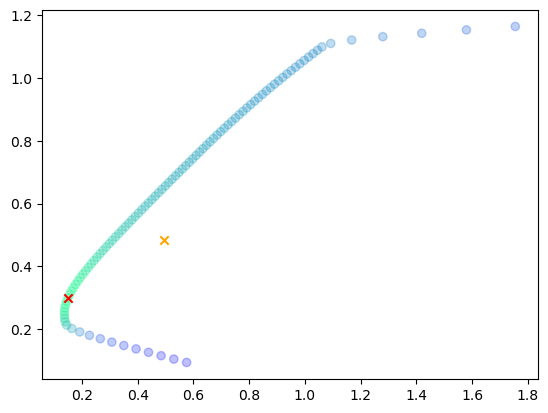

In [67]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [68]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [69]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,937.082794,0.504495,0.0315,0.472995
SOLUSDT,269.730253,0.145214,0.0000,0.145214
JASMYUSDT,182.426780,0.098213,0.0000,0.098213
ETHUSDT,174.907876,0.094165,0.0000,0.094165
OMUSDT,140.906107,0.075859,0.0081,0.067759
TRXUSDT,138.578374,0.074606,0.0257,0.048906
BBUSDT,12.723853,0.006850,0.0000,0.006850
BNBUSDT,1.110232,0.000598,0.0600,-0.059402
PEPEUSDT,0.000003,0.000000,0.0196,-0.019600
PAXGUSDT,0.000000,0.000000,0.3950,-0.395000


### Current results

In [71]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [72]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
PAXGUSDT,0.830199
BTCUSDT,0.104301
TRXUSDT,0.065500


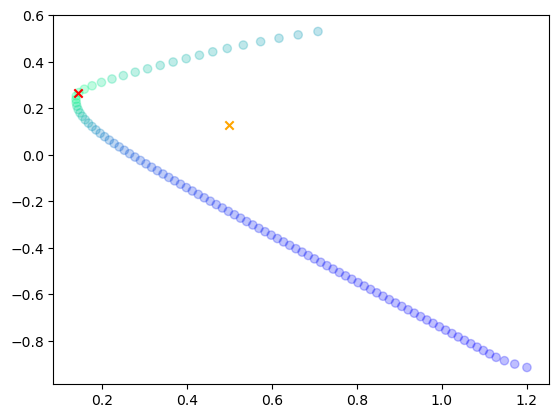

In [73]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [74]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,937.082794,0.504495,0.104301,0.400194
SOLUSDT,269.730253,0.145214,0.000000,0.145214
JASMYUSDT,182.426780,0.098213,0.000000,0.098213
ETHUSDT,174.907876,0.094165,0.000000,0.094165
OMUSDT,140.906107,0.075859,0.000000,0.075859
TRXUSDT,138.578374,0.074606,0.065500,0.009106
BBUSDT,12.723853,0.006850,0.000000,0.006850
BNBUSDT,1.110232,0.000598,0.000000,0.000598
PEPEUSDT,0.000003,0.000000,0.000000,0.000000
PAXGUSDT,0.000000,0.000000,0.830199,-0.830199


# Risk Reward Analysis

In [76]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [77]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

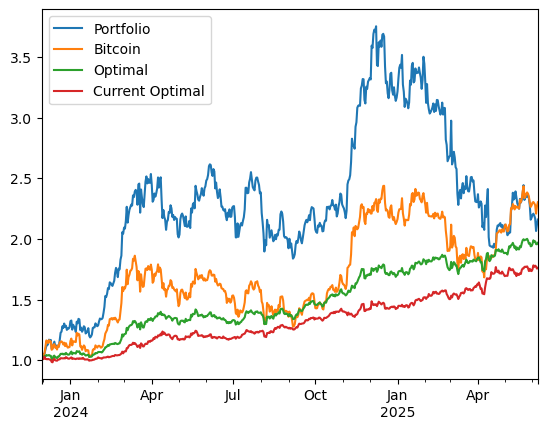

In [78]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [79]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

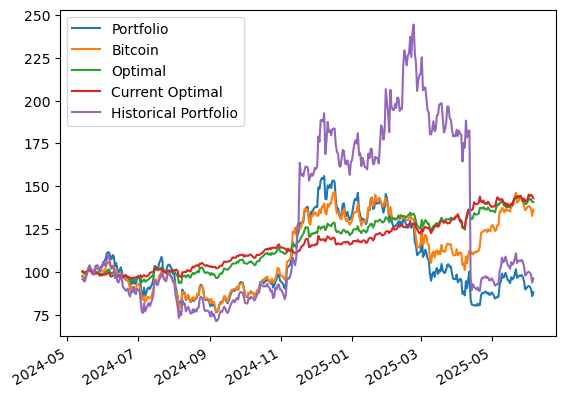

In [80]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [81]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-05-28,96.962354,140.971416,141.056236,141.308009,105.710625
2025-05-29,94.598872,138.074831,141.504077,142.827677,103.099121
2025-05-30,89.738820,135.960901,139.552141,141.467833,97.892811
2025-05-31,90.411352,136.751466,139.683167,141.304436,98.620214
2025-06-01,91.402745,138.118830,140.901131,142.445181,99.692804
2025-06-02,91.783143,138.399717,143.084843,145.132258,100.129980
2025-06-03,91.138369,137.769288,142.175673,144.131523,99.420893
2025-06-04,90.114450,136.877339,142.506310,144.950438,98.339966
2025-06-05,85.861231,132.644433,140.860189,144.399366,93.820926
2025-06-06,88.077871,136.227982,140.743814,142.965749,96.220638


## Volatilities

In [83]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.177774
 dtype: float64,
 0.17793275808775635)

In [84]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.499972
 dtype: float64,
 0.49997223580424616)

In [85]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.495465
Bitcoin            0.424081
Optimal            0.177933
Current Optimal    0.140288
dtype: float64

In [86]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.5744598987528677

In [87]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

0.8783482504460526

In [88]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.258083152226934

## Risk Contribution

In [90]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.391178,0.300000,0.423032,0.593890,0.511245,0.082645
OMUSDT,-0.190702,0.014429,-0.107887,0.048617,0.020249,0.028369
PAXGUSDT,0.390515,0.639303,0.630294,0.302136,0.264039,0.038097
TRXUSDT,0.042878,0.046268,0.054561,0.055356,0.025593,0.029764
Portfolio,0.633868,1.000000,1.000000,1.000000,0.821126,0.178874


In [91]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.050255,0.104301,0.107693,0.132660,0.087628,0.045032
TRXUSDT,0.041478,0.065500,0.074541,0.131526,0.105039,0.026487
PAXGUSDT,0.343425,0.830199,0.817766,0.735814,0.700641,0.035173
Portfolio,0.435159,1.000000,1.000000,1.000000,0.893308,0.106692


In [92]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.240913,0.50,0.753547,0.361378,0.165270,0.196109
SOLUSDT,-0.047158,0.15,0.104596,0.182824,0.046295,0.136529
JASMYUSDT,-0.067424,0.10,0.033131,0.166285,0.046204,0.120082
ETHUSDT,-0.031931,0.09,0.059059,0.089469,0.011889,0.077580
OMUSDT,-0.146290,0.08,-0.067421,0.149080,0.086782,0.062297
TRXUSDT,0.044328,0.07,0.116278,0.034389,0.009846,0.024544
BBUSDT,-0.009204,0.01,0.000810,0.016574,0.000577,0.015997
Portfolio,-0.016766,1.00,1.000000,1.000000,0.366863,0.633137


In [93]:
ptf_evolution=((1+current_risk.returns).cumprod()*current_weights)
initial_weights=current_risk.inventory(current_weights)

last_nav=ptf_evolution.iloc[-1].sum()
last_row=ptf_evolution.iloc[-1]
last_weight=last_row/last_nav

perf=last_row/current_weights
perf_contrib=(perf-1)*current_weights

perf_report=pd.concat([perf_contrib,initial_weights,last_weight],axis=1)
perf_report.columns=['Performance Contribution','Initial Weights','Last Weights']
perf_report.loc['Portfolio']=perf_report.sum(axis=0)

perf_report.dropna()

,Performance Contribution,Initial Weights,Last Weights
BTCUSDT,0.240913,0.50,0.753547
SOLUSDT,-0.047158,0.15,0.104596
JASMYUSDT,-0.067424,0.10,0.033131
ETHUSDT,-0.031931,0.09,0.059059
OMUSDT,-0.146290,0.08,-0.067421
TRXUSDT,0.044328,0.07,0.116278
BBUSDT,-0.009204,0.01,0.000810
Portfolio,-0.016766,1.00,1.000000


# Value At Risk

## Historical

### Optimal Weights

In [97]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.028704230933426163, -0.03605265071575379)

### Current Weights

In [99]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.0845062823756726, -0.11370596368488543)

In [100]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [101]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.025058
SOLUSDT     -0.025368
JASMYUSDT   -0.016107
ETHUSDT     -0.010345
OMUSDT      -0.004538
TRXUSDT     -0.001699
BBUSDT      -0.001379
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT     0.000000
Portfolio   -0.084493
Name: 2025-02-24 00:00:00, dtype: float64

In [102]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.025906
SOLUSDT     -0.019352
JASMYUSDT   -0.012801
ETHUSDT     -0.009199
OMUSDT      -0.035175
TRXUSDT     -0.003734
BBUSDT      -0.001697
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.107863
dtype: float64

## Parametric

### Optimal Weights

In [105]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.026075359121912185, -0.03229603800958101)

### Current Weights

In [107]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.07326900195157578, -0.09074845185789443)

## Multivariate

### Optimal Weights

In [110]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.02486577704175333, -0.02872132494516506)

### Current Weights

In [112]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07242869726578884, -0.08428908848887756)

In [113]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.024418
SOLUSDT     -0.013590
JASMYUSDT   -0.012601
ETHUSDT     -0.006212
OMUSDT      -0.011996
TRXUSDT     -0.002859
BBUSDT      -0.001187
Portfolio   -0.072862
dtype: float64

In [114]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.023518
SOLUSDT     -0.013364
JASMYUSDT   -0.013329
ETHUSDT     -0.006346
OMUSDT      -0.012810
TRXUSDT     -0.003261
BBUSDT      -0.001164
Portfolio   -0.073792
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [118]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.02442199711458712, -0.028204647718446926)

### Current Weights

In [120]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0704320200547786, -0.08183093377723814)

In [121]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [124]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.024738189501849056, -0.028653509603222157)

### Current Weights

In [126]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07431411345565708, -0.08541909349495008)

In [127]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [130]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.056121456912795416, -0.06890394457670893)

### Current Weights

In [132]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.09886931629195307, -0.11908490177576575)

In [133]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [136]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [137]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.025706501378060128, -0.029904548377115817)

### Current Weights

In [139]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0767592683924383, -0.08568051982146553)

In [140]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [141]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.029851,-0.025283,-0.017816,-0.024418,-0.025327
SOLUSDT,-0.008409,-0.013287,-0.009008,-0.013590,-0.013966
JASMYUSDT,-0.005674,-0.012796,-0.009195,-0.012601,-0.012684
ETHUSDT,-0.002514,-0.006535,-0.004732,-0.006212,-0.006667
OMUSDT,-0.017435,-0.011209,-0.009150,-0.011996,-0.012179
TRXUSDT,-0.001709,-0.002298,-0.002161,-0.002859,-0.002519
BBUSDT,-0.000236,-0.001391,-0.000914,-0.001187,-0.001289
Portfolio,-0.065826,-0.072798,-0.052976,-0.072862,-0.074632


In [142]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.030673,-0.026128,-0.017039,-0.023518,-0.025778
SOLUSDT,-0.009078,-0.013707,-0.008258,-0.013364,-0.013091
JASMYUSDT,-0.003123,-0.012644,-0.009823,-0.013329,-0.013055
ETHUSDT,-0.002994,-0.006985,-0.004886,-0.006346,-0.006965
OMUSDT,-0.018640,-0.010666,-0.009863,-0.012810,-0.012949
TRXUSDT,-0.001855,-0.002242,-0.002704,-0.003261,-0.002367
BBUSDT,-0.000296,-0.001395,-0.000984,-0.001164,-0.001373
Portfolio,-0.066659,-0.073767,-0.053557,-0.073792,-0.075577


## VaR Violation

In [144]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.021035,-0.021564,-0.020581,-0.008196
2024-01-15,-0.021035,-0.021940,-0.020893,0.010304
2024-01-16,-0.021035,-0.021768,-0.020418,-0.001191
2024-01-17,-0.021035,-0.021497,-0.020756,-0.007417
2024-01-18,-0.021035,-0.021766,-0.021336,-0.007432
...,...,...,...,...
2025-06-03,-0.014444,-0.023076,-0.020482,-0.006354
2025-06-04,-0.014444,-0.021921,-0.020277,0.002326
2025-06-05,-0.014444,-0.021389,-0.021094,-0.011551
2025-06-06,-0.014444,-0.021269,-0.020900,-0.000826


In [145]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.026010,-0.078589,-0.070516,-0.016390
2024-05-29,-0.019423,-0.076294,-0.069523,-0.009519
2024-05-30,-0.019423,-0.063640,-0.055363,0.025558
2024-05-31,-0.019423,-0.062314,-0.054022,0.007398
2024-06-01,-0.019423,-0.060971,-0.053219,0.019322
...,...,...,...,...
2025-06-03,-0.051167,-0.054164,-0.057152,-0.007025
2025-06-04,-0.051167,-0.053797,-0.057781,-0.011235
2025-06-05,-0.051167,-0.056463,-0.064887,-0.047198
2025-06-06,-0.051167,-0.055647,-0.064846,0.025817


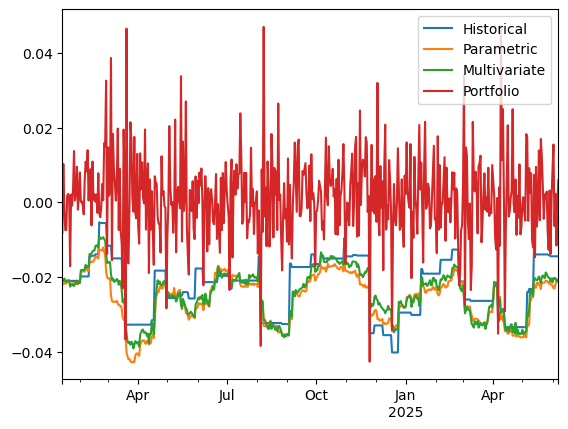

In [146]:
var_data.plot()
plt.show()

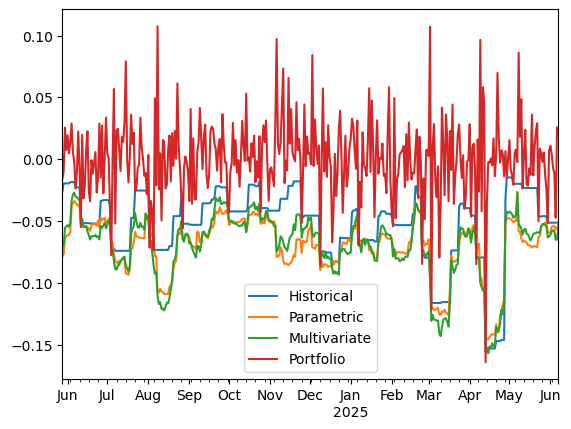

In [147]:
current_var_data.plot()
plt.show()


In [148]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.031311,0.013699,0.017613
Kupiec Stat,4.309097,19.673792,14.87649
P-value,0.037909,0.000009,0.000115


In [149]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.077128,0.021277,0.018617
Kupiec Stat,5.033538,8.252652,10.154333
P-value,0.024861,0.004069,0.00144


# Principal Component Analysis

## Historical PCA

In [152]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.76865445, 0.09936617, 0.05609039, 0.03936257, 0.03652642])

In [153]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.018355
ADAUSDT      0.019090
ALGOUSDT     0.020270
APTUSDT      0.018134
ARBUSDT      0.020668
ATOMUSDT     0.017444
AVAXUSDT     0.020162
BCHUSDT      0.015711
BNBUSDT      0.009052
BONKUSDT     0.025791
BTCUSDT      0.010046
CAKEUSDT     0.018537
CRVUSDT      0.021343
DOGEUSDT     0.019814
DOTUSDT      0.018135
ENSUSDT      0.021668
ETCUSDT      0.016788
ETHUSDT      0.014694
FDUSDUSDT    0.000072
FETUSDT      0.023628
FILUSDT      0.020023
FLOKIUSDT    0.024987
GRTUSDT      0.022154
HBARUSDT     0.018937
ICPUSDT      0.018188
IMXUSDT      0.021219
INJUSDT      0.021882
JASMYUSDT    0.022086
LDOUSDT      0.022094
LINKUSDT     0.018471
LTCUSDT      0.013705
MKRUSDT      0.014040
NEARUSDT     0.022350
NEXOUSDT     0.011482
OMUSDT       0.014573
OPUSDT       0.021138
PAXGUSDT     0.000137
PEPEUSDT     0.026026
QNTUSDT      0.015360
SANDUSDT     0.021471
SEIUSDT      0.021663
SHIBUSDT     0.018963
SOLUSDT      0.016932
STXUSDT      0.021396
SUIUSDT      0.018995
THETAUSDT 

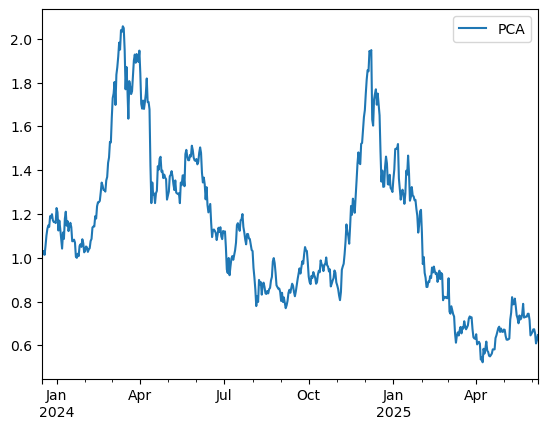

In [154]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

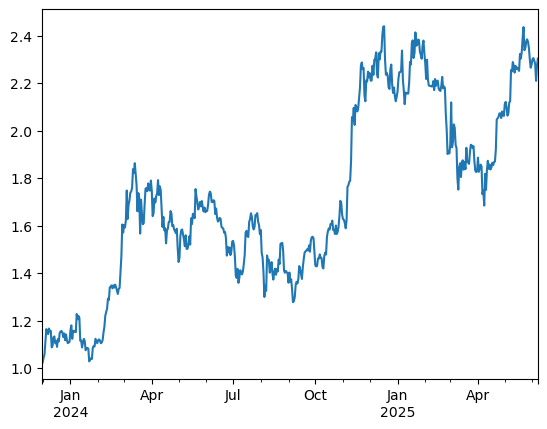

In [155]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [156]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
WBETHUSDT    0.484999
ETHUSDT      0.485254
ETCUSDT      0.499746
DOTUSDT      0.511973
ATOMUSDT     0.535832
AVAXUSDT     0.572399
NEXOUSDT     0.574881
FILUSDT      0.579688
WBTCUSDT     0.599985
BTCUSDT      0.600318
GRTUSDT      0.605096
ARBUSDT      0.613020
LINKUSDT     0.624438
VETUSDT      0.640902
ALGOUSDT     0.653644
SOLUSDT      0.681995
THETAUSDT    0.683813
IMXUSDT      0.702907
DOGEUSDT     0.705494
dtype: float64

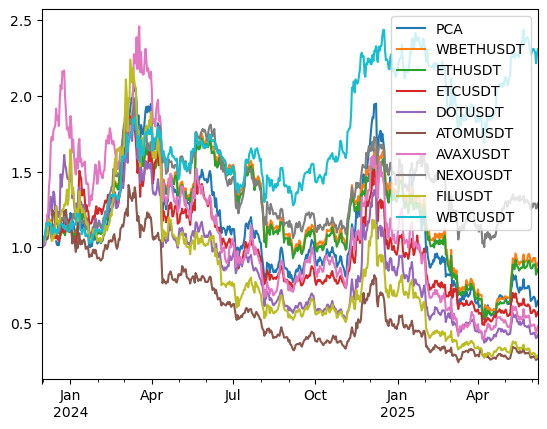

In [157]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

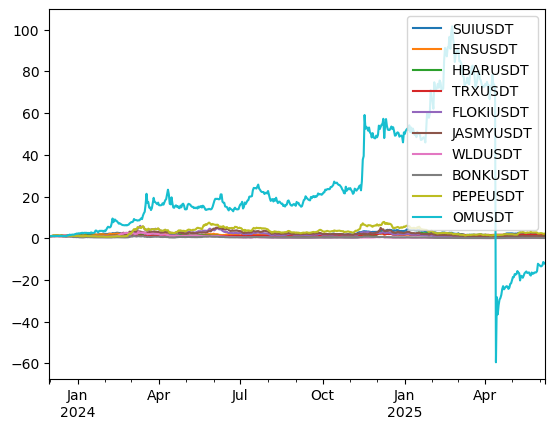

In [158]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [160]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.51055077, 0.3134465 , 0.07218662, 0.06043401, 0.04338209])

In [161]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.050316
SOLUSDT      0.090975
JASMYUSDT    0.136640
ETHUSDT      0.077414
OMUSDT       0.260889
TRXUSDT      0.035476
BBUSDT       0.162811
BNBUSDT      0.051062
PEPEUSDT     0.133012
PAXGUSDT     0.001405
Name: PC1, dtype: float64

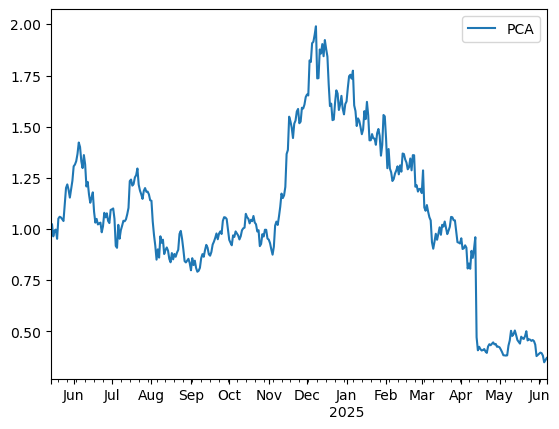

In [162]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()
plt.show()

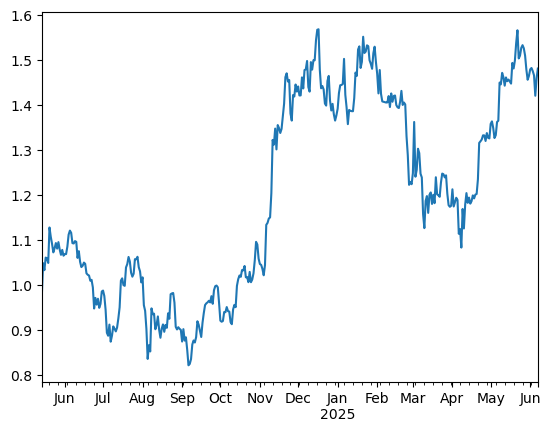

In [163]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [164]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.738299
SOLUSDT      0.769776
BTCUSDT      0.772268
BNBUSDT      0.779780
JASMYUSDT    0.986652
PAXGUSDT     1.011713
PEPEUSDT     1.024580
BBUSDT       1.034970
TRXUSDT      1.147079
dtype: float64

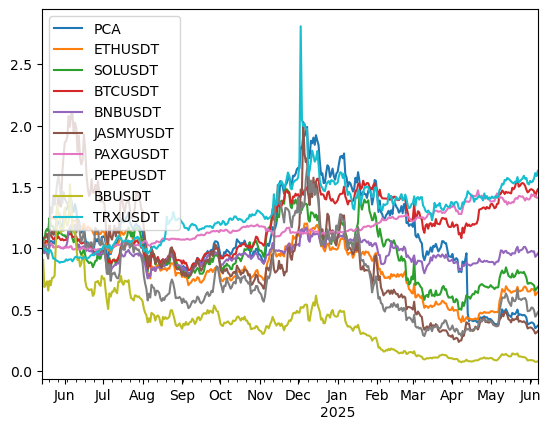

In [165]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [167]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.905966
BBUSDT       1.609019
JASMYUSDT    1.436217
SOLUSDT      1.272080
ETHUSDT      1.077046
BTCUSDT      1.000000
OMUSDT       0.966281
BNBUSDT      0.660270
TRXUSDT      0.323057
PAXGUSDT     0.030669
Name: BTCUSDT, dtype: float64

In [168]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       3.179963
PEPEUSDT     3.032035
OMUSDT       2.940405
JASMYUSDT    2.025961
SOLUSDT      1.417508
ETHUSDT      1.371558
BTCUSDT      1.000000
BNBUSDT      0.862522
TRXUSDT      0.146621
PAXGUSDT     0.015985
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [170]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [171]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
PEPEUSDT,0.225585
ETHUSDT,0.207789
JASMYUSDT,0.184334
BTCUSDT,0.183132
OMUSDT,0.151928
TRXUSDT,0.125718
SOLUSDT,0.103404
PAXGUSDT,-0.009421
BBUSDT,-0.016180
BNBUSDT,-0.072935


### Regression to PCA

In [173]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.6246800305534808

In [174]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.364740
BNBUSDT      1.225316
PCA          1.000000
ETHUSDT      0.978274
SOLUSDT      0.754918
JASMYUSDT    0.490098
PEPEUSDT     0.477805
BBUSDT       0.433176
TRXUSDT      0.293378
PAXGUSDT     0.283899
OMUSDT       0.106498
dtype: float64

In [175]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      2.028138
BNBUSDT      1.519346
SOLUSDT      1.232110
TRXUSDT      1.201863
ETHUSDT      1.055921
PCA          1.000000
JASMYUSDT    0.800797
PEPEUSDT     0.618461
OMUSDT       0.527629
BBUSDT       0.512664
PAXGUSDT    -0.033847
dtype: float64

### Correlation Matrix

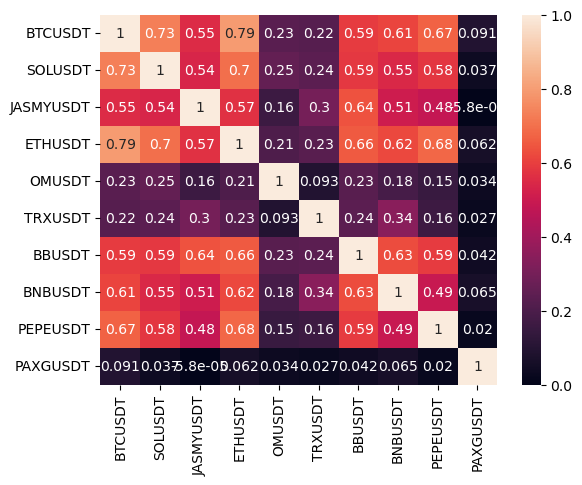

In [177]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

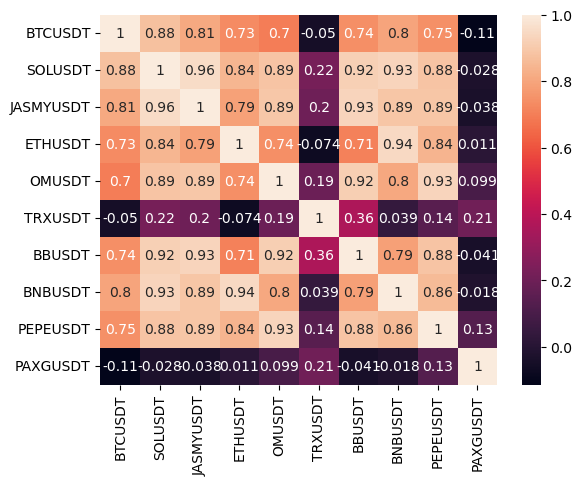

In [178]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [179]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [180]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

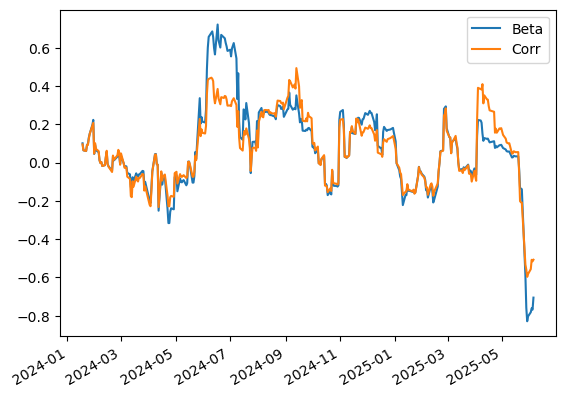

In [181]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [183]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,OMUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.483880,0.000000,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.000000,0.150876,0.000000,0.626168,0.222957,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.223616,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.260704,0.086231,0.000000,0.000000,0.019283,0.238042,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.453916,0.000000,0.000000,0.000000,0.546084
2024-09-02,0.000000,0.000000,0.000000,0.000000,0.435186,0.564814,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.000000,0.000000,0.166022,0.176734,0.526886,0.000000,0.000000,0.130357,0.000000


In [184]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,ZECUSDT
2024-10-30,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.195045,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.033288
2024-11-29,0.000000,0.0,0.006904,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.01541,0.045475,0.000000
2024-12-29,0.816741,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.004820,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000
2025-01-28,0.000006,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.112825,0.000000
2025-02-27,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000
2025-03-29,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.010324,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000
2025-04-28,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.115861,...,0.102883,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000
2025-05-28,0.395426,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.297568
2025-06-07,0.041713,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.411368,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000


In [185]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

TRXUSDT      0.411368
PAXGUSDT     0.348226
FDUSDUSDT    0.198693
AAVEUSDT     0.041713
SOLUSDT      0.000000
MKRUSDT      0.000000
Name: 2025-06-07 00:00:00, dtype: float64

In [186]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
